In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, AveragePooling2D, GlobalAveragePooling2D,Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

2025-05-24 19:57:25.971277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748116646.143082      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748116646.194600      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def dense_block(x, num_layers, growth_rate):
    """
    Creates a dense block with `num_layers` of densely connected convolutional layers
    growth_rate: Number of filters to add per layer (k in paper)
    """
    for _ in range(num_layers):
        # Bottleneck layer (1x1 conv to reduce feature maps)
        bn = BatchNormalization()(x)
        relu = ReLU()(bn)
        conv1x1 = Conv2D(4 * growth_rate, (1, 1), padding='same', use_bias=False)(relu)
        
        # 3x3 convolution
        bn = BatchNormalization()(conv1x1)
        relu = ReLU()(bn)
        conv3x3 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(relu)
        
        # Concatenate with original input
        x = concatenate([x, conv3x3])
    return x

This function implements a DenseNet “dense block,” stacking num_layers pairs of 1×1 bottleneck and 3×3 convolutional layers. Each layer produces growth_rate new feature maps, which are then concatenated with all previous feature maps to encourage maximum feature reuse and efficient gradient flow.

In [3]:
def transition_layer(x, compression=0.5):
    """
    Reduces feature maps by `compression` factor and halves spatial dimensions
    """
    filters = int(tf.keras.backend.int_shape(x)[-1] * compression)
    
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x

This function implements a DenseNet “transition layer,” which first applies batch normalization and ReLU, then uses a 1×1 convolution to reduce the number of feature maps by the given compression factor.
Finally, it halves the spatial dimensions with 2×2 average pooling to control model complexity and prepare for the next dense block.

In [4]:
def build_densenet121(input_shape=(224, 224, 3), num_classes=4, growth_rate=48):
    inputs = Input(shape=input_shape)
    
    # Initial convolution
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)
    
    # Dense Blocks and Transition Layers (DenseNet-121 configuration: 6,12,24,16)
    # Block 1
    x = dense_block(x, num_layers=6, growth_rate=growth_rate)
    x = transition_layer(x)
    
    # Block 2
    x = dense_block(x, num_layers=12, growth_rate=growth_rate)
    x = transition_layer(x)
    
    # Block 3
    x = dense_block(x, num_layers=24, growth_rate=growth_rate)
    x = transition_layer(x)
    
    # Block 4 (no transition after last block)
    x = dense_block(x, num_layers=16, growth_rate=growth_rate)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

model = build_densenet121()
model.summary()

I0000 00:00:1748116661.461994      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,408 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ average_pooling2d[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 192)    │         12,288 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 192)    │            768 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 192)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 48)     │         82,944 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 112)    │              0 │ average_pooling2d[0][… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 112)    │            448 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 112)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 192)    │         21,504 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 192)    │            768 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 15,524,628 (59.22 MB)

 Trainable params: 15,408,948 (58.78 MB)

 Non-trainable params: 115,680 (451.88 KB)

This function defines the DenseNet-121 architecture: it starts with a 7×7 convolution, batch norm, ReLU, and 3×3 average pooling to downsample the input.
It then stacks four dense blocks (with 6, 12, 24, and 16 layers respectively), inserting transition layers (1×1 conv + pooling) between the first three to compress feature maps and halve spatial resolution.
After the final dense block, it applies global average pooling and a softmax dense layer to produce num_classes output probabilities.

In [5]:
base_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder'
train_data_dir = os.path.join(base_dir, 'train')
valid_data_dir = os.path.join(base_dir, 'valid')
test_data_dir  = os.path.join(base_dir, 'test')


# Verify paths
assert os.path.exists(base_dir), "Base directory not found!"
assert os.path.exists(train_data_dir), "Train directory not found!"
assert os.path.exists(test_data_dir), "Test directory not found!"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          
    width_shift_range=0.3,    
    height_shift_range=0.3,    
    shear_range=0.3,           
    zoom_range=0.3,            
    horizontal_flip=True,
    vertical_flip=True,        
    brightness_range=[0.7, 1.3],  
    channel_shift_range=50,     
    fill_mode='nearest',        
    validation_split=0.2
)

# Validation and Test Generators (No augmentation for validation/test)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42  
)

validation_generator = validation_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Classes: {train_generator.class_indices}")

Found 800 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Classes: {'Angry': 0, 'Other': 1, 'Sad': 2, 'happy': 3}


This snippet sets up the file paths for training, validation, and test splits, ensuring the base and subdirectories exist.
It then defines a single ImageDataGenerator with data augmentation (rescaling, rotations, shifts, shearing, zoom, flips) and a 20% validation split, and creates separate generators for training and validation from the same train folder.
A simpler generator is created for the test set with only rescaling, and classes are inferred automatically, with num_classes and the class-to-index mapping printed.

In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ModelCheckpoint('densenet_from_scratch.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 48,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 48,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748116751.073114      57 service.cc:148] XLA service 0x7b0a4c003200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748116751.074057      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748116759.149123      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748116839.235177      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/16 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.2797 - loss: 1.5748

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16/16 ━━━━━━━━━━━━━━━━━━━━ 283s 7s/step - accuracy: 0.2816 - loss: 1.5738 - val_accuracy: 0.2650 - val_loss: 1.3866
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 746ms/step - accuracy: 0.2841 - loss: 1.4890 - val_accuracy: 0.2500 - val_loss: 1.3955
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 761ms/step - accuracy: 0.3135 - loss: 1.4145 - val_accuracy: 0.2500 - val_loss: 1.4007
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 772ms/step - accuracy: 0.2707 - loss: 1.4146 - val_accuracy: 0.2500 - val_loss: 1.4226
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 734ms/step - accuracy: 0.3367 - loss: 1.4187 - val_accuracy: 0.2500 - val_loss: 1.4634
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 810ms/step - accuracy: 0.3376 - loss: 1.4269 - val_accuracy: 0.2500 - val_loss: 1.4720
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 850ms/step - accuracy: 0.3397 - loss: 1.4327 - val_accuracy: 0.2500 - val_loss: 1.6258
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 795ms/step - accuracy: 0.3555 - loss: 1.3689 - val_accuracy: 0.2500 

This block compiles the model with the Adam optimizer (learning rate 1e-4), categorical crossentropy loss, and accuracy metric.
It sets up early stopping (patience 6, restoring best weights) and checkpointing to save only the best model.
Finally, it trains for up to 50 epochs on the augmented training generator, validating on the held-out split each epoch and using batch size 32.
Training stops early if the validation loss doesn’t improve for six consecutive epochs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.3684 - loss: 1.3830

Test Accuracy: 36.84%
Test Loss: 1.3830

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.50      0.50        10
       Other       0.00      0.00      0.00         6
         Sad       0.00      0.00      0.00        11
       happy       0.32      0.82      0.46        11

    accuracy                           0.37        38
   macro avg       0.21      0.33      0.24        38
weighted avg       0.22      0.37      0.27        38



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


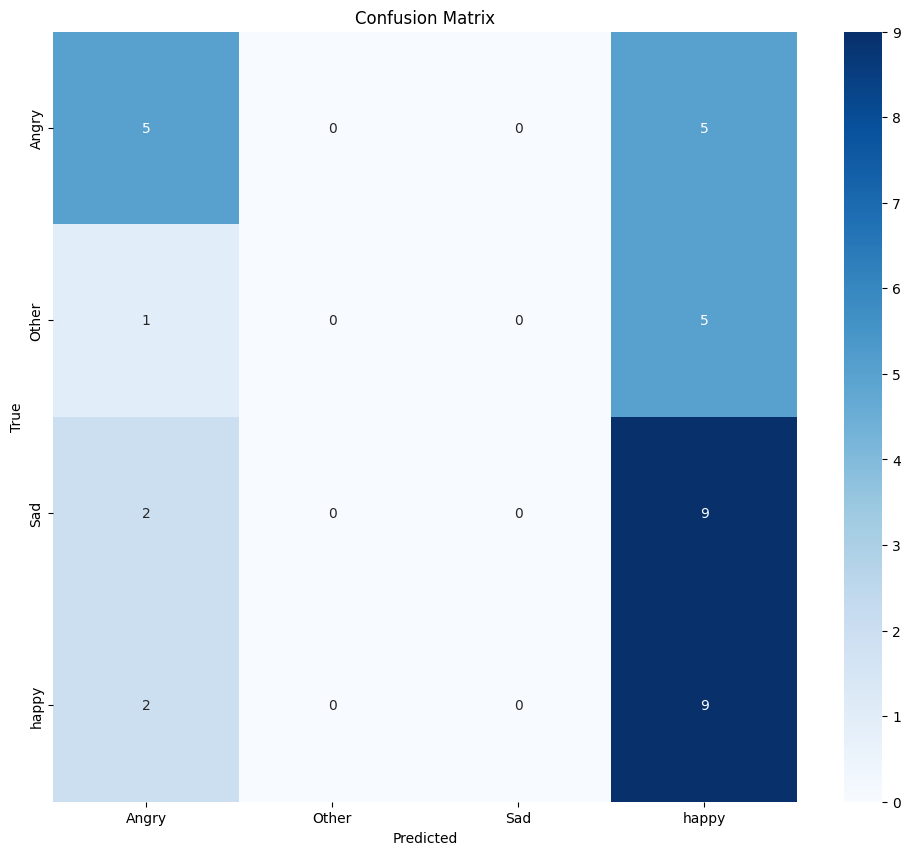


Macro Averages:
Mean Precision: 0.2054
Mean Recall: 0.3295
Mean F1-Score: 0.2404


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Load best weights
model.load_weights('densenet_from_scratch.h5')

# Evaluate on test set to get loss and accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}\n")

# Generate predictions
Y_pred = model.predict(test_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = test_generator.classes
class_names = list(train_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(Y_true, Y_pred_classes), 
            annot=True, fmt='d', 
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Macro Metrics from classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_names, output_dict=True)
print("\nMacro Averages:")
print(f"Mean Precision: {report['macro avg']['precision']:.4f}")
print(f"Mean Recall: {report['macro avg']['recall']:.4f}")
print(f"Mean F1-Score: {report['macro avg']['f1-score']:.4f}")